# **社群媒體分析_期末專案**

* **組員：M094810008 黃子源、M094030040 孫亦農、M104020058 黃弘瑋、M094111006 呂奕憲**

資料內容：
資料來源：ptt八卦版 (共3461筆) & ptt政黑版（共2935筆）
* **分析主題：罷免陳柏惟事件之社群討論_以PTT為例**

## 大綱
+ **1. 套件及資料載入**
+ **2. 文字前處理**
    + 2.1 資料描述
    + 2.2 斷詞
+ **3.情緒分析及模型預測**
    + 3.1 計算情緒分數
    + 3.2 將資料切成訓練集與測試集
    + 3.3 將文章轉為DTM
    + 3.4 比較不同模型和資料組合的訓練組合
  
+ **4.LDA 主題模型**
    + 4.1 訓練LDA模型
    + 4.2 查看 LDA 主題代表字
    + 4.3 查看 LDA 模型指標
    + 4.4 透過指標找出最佳主題數
    + 4.5 視覺化呈現
        + 4.5.1 產生 LDAvis 結果
        + 4.5.2 資料內容探索
+ **5.社群網路圖**
    + 5.1 基本網路圖
    + 5.2 資料篩選
    + 5.3 以日期篩選社群
    + 5.4 以主題篩選社群
    + 5.5 使用者是否受到歡迎

## 1. 套件及資料載入

In [1]:
import pandas as pd
import re
import time
import string
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import jieba

import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']  #使中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯

In [2]:
MetaData_gossip = pd.read_csv('Data/bowei_gossip_articleMetaData.csv')
MetaData_hatepolitic=pd.read_csv('Data/bowei_HatePolitics_articleMetaData.csv')
MetaData_gossip

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[問卦]江福戀很重要嗎？,2021/03/04,18:10:09,https://www.ptt.cc/bbs/Gossiping/M.1614881411....,whiteadam,Gossiping,5,0,1,不重要\n可是你太不了解台灣人了\n\n台灣人對於真正的國家大事反而沒有很關心\n\n例如 ...
1,Re:[問卦]有沒有1949年大撤退的八卦？,2021/03/05,00:56:45,https://www.ptt.cc/bbs/Gossiping/M.1614905807....,a874622,Gossiping,8,5,1,搞定台灣比搞定300倍的大陸一樣嗎?\n搞定台灣台籍日本兵 搞定彭德懷懷林彪一樣嗎?\n川普...
2,[問卦]遇到顯示「一接就掛」會掛他電話嗎？,2021/03/05,05:11:46,https://www.ptt.cc/bbs/Gossiping/M.1614921110....,Lucky0105,Gossiping,20,6,1,https://i.imgur.com/tnB3qlE.jpg\n像whoscall顯示一接...
3,[新聞]「關你什麼事！」藍綠年輕女發言人隔空,2021/03/05,05:37:42,https://www.ptt.cc/bbs/Gossiping/M.1614922665....,area41gold,Gossiping,164,107,9,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新頭殼\n\n2.記者署名:\n黃...
4,Re:[新聞]獨家》迎戰藻礁公投 民進黨高層：,2021/03/05,05:54:48,https://www.ptt.cc/bbs/Gossiping/M.1614923691....,gmooshan,Gossiping,2,0,1,我們的智商很高\n知識水準也很高\n智力測驗都有過\n電視只看自民三\n\n\n只能說 如果...
...,...,...,...,...,...,...,...,...,...,...
6514,Re:[新聞]馬英九：封存核四就是為了未來可以啟封,2021/10/31,10:17:32,https://www.ptt.cc/bbs/Gossiping/M.1635675454....,hortl233,Gossiping,139,53,8,幹你娘的看到這句話就想笑\n\n回顧2014年前後發生什麼事?\n\n2013年22萬人上街...
6515,[新聞]中二立委補選確定林靜儀參戰？綠要角：當,2021/10/31,12:13:06,https://www.ptt.cc/bbs/Gossiping/M.1635682389....,Ganam56Style,Gossiping,21,8,0,1.媒體來源:\n自由\n\n2.記者署名:\n〔記者唐在馨／台中報導〕\n\n3.完整新聞...
6516,[問卦]3+11800被忘光了嗎,2021/10/31,13:30:13,https://www.ptt.cc/bbs/Gossiping/M.1635687015....,dc1230,Gossiping,26,6,7,半年前有個疫情\n\n看起來是因為3+11的關係 導致疫情擴散開來\n還因此死了800人\n...
6517,[新聞]美國已在美豬議題表態了！學者列8點：美,2021/10/31,13:48:37,https://www.ptt.cc/bbs/Gossiping/M.1635688119....,xingting,Gossiping,173,16,15,newtalk\n蕭羽秀\n\n\n美國已在美豬議題表態了！學者列8點：美國怎能相信朱立倫？...


In [3]:
keywords = ['罷免','伯惟','柏惟','柏維','刪Q','基進','選罷法','報復性','寬恆','顏家','惡罷','惡意罷免','三Q','3Q']
toMatch = '|'.join(keywords)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
MetaData_gossip = MetaData_gossip.loc[MetaData_gossip['artTitle'].str.contains(toMatch), :]
MetaData_gossip.reset_index(inplace=True, drop=True) 
MetaData_hatepolitic = MetaData_hatepolitic.loc[MetaData_hatepolitic['artTitle'].str.contains(toMatch), :]
MetaData_hatepolitic.reset_index(inplace=True, drop=True) 
print("PTT八卦版總共有 ",MetaData_gossip.shape[0],"篇貼文""\nPTT政黑板總共有",MetaData_hatepolitic.shape[0],"篇貼文")

PTT八卦版總共有  3461 篇貼文
PTT政黑板總共有 2935 篇貼文


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


合併資料

In [5]:
MetaData = pd.concat([MetaData_gossip,MetaData_hatepolitic],axis=0).reset_index() 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.文字前處理

### 2.1 資料描述

來源：PTT八卦版、PTT政黑板
* **資料期間：2021/03/05 ~ 2021/10/31** 隨機選1000篇文章。

In [6]:
metadata = MetaData.sample(n=1000, random_state=2021).reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


斷句

In [7]:
def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 斷句符號
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略號
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    para = para.rstrip()  # 去掉句尾多餘的空白
    para = re.split("\r|[\n]+",para) # 找到一個或多個\n都可以斷句
    para_list = list(filter(None, para))
    return para_list 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:2: DeprecationWarning: invalid escape sequence \?
<>:3: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \?
<>:2: DeprecationWarning: invalid escape sequence \?
<>:3: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \?
<>:2: DeprecationWarning: invalid escape sequence \?
<>:3: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \?
<ipython-input-7-4cc5bd143b20>:2: DeprecationWarning: invalid escape sequence \?
  para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 斷句符號
<ipython-input-7-4cc5bd

In [8]:
metadata['content'] = metadata['artTitle'] + metadata['sentence']
books = metadata.dropna() #去掉空白欄位
data = books[['content','artUrl']] #文章內容 文章連結data.head(3)

# 把句子切開
data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開
data = data[['sentence','artUrl']].explode("sentence")
data['document'] = range(0, len(data))
data.head(3)
 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sentence,artUrl,document
0,Re:[問卦]總統我投票選的，想罷免我要聽立委的？,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,0
0,很簡單啊 先把立委都罷免掉,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,1
0,等罷到可以罷免總統程度的時侯,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,2


In [9]:
def load_stop_words(path):
    with open(path,encoding="utf-8") as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典    
    sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


查看「陳柏維事件」的相關報導在時間上的數量走勢

In [10]:
# groupby artDate 轉為新的DataFrame
day_count = pd.DataFrame({
    'date': metadata.groupby('artDate').size().index,
    'count': metadata.groupby('artDate').size().values
})
day_count = day_count.sort_values(by='date') # 排序
day_count.date = pd.to_datetime(day_count['date']) # 將裡面資料轉為日期格式

day_count

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,count
0,2021-03-05,1
1,2021-03-06,3
2,2021-03-09,1
3,2021-03-10,1
4,2021-03-12,1
...,...,...
123,2021-10-27,10
124,2021-10-28,5
125,2021-10-29,7
126,2021-10-30,5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


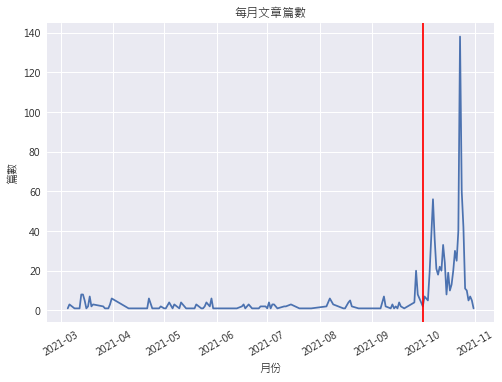

In [137]:
plt.style.use('seaborn') 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.plot(day_count['date'], day_count['count'])
plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30) # 旋轉x刻度避免重疊
plt.axvline('2021-10',color= 'red')
plt.show()

發文高峰為罷免投票階段的10月份

### 2.2 斷詞
* 進行斷詞
* 去除標點符號
* 去除stopwords
* 篩選出現太少次的字

In [12]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
jieba.set_dictionary('./dict/dict.txt') 

# 自定義辭典
 
jieba.load_userdict('./dict/bowei_dict.txt')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Building prefix dict from C:\Users\ASUS\Desktop\Master_Program\Lectures\3rd_semester\社群媒體分析\final_project\dict\dict.txt ...
Dumping model to file cache C:\Users\ASUS\AppData\Local\Temp\jieba.ub6a2e22769579463543b8292d3f0ff8b.cache
Loading model cost 1.270 seconds.
Prefix dict has been built successfully.


In [13]:
def load_stop_words(path):
    with open(path,encoding='utf-8') as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典    
    sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
#去除新聞常用字
data['sentence'] = data.sentence.apply(lambda x: re.sub('(完整內容|新聞|新聞網址|新聞來源|媒體來源|記者署名|網址來源|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
data['sentence'] = data.sentence.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))
data['sentence'] = data.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',str(x)))
data['sentence'] = data.sentence.apply(lambda x: re.sub('\\n{1,2}', ',', x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
stop_path = 'dict/stopwords.txt'
user_path = "dict/user_dict.txt"

data['clean_txt'] = data.apply(lambda row : get_tokens(row['sentence'],user_path,stop_path), axis=1) 
data.head(5)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sentence,artUrl,document,clean_txt
0,問卦總統我投票選的想罷免我要聽立委的,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,0,問卦 總統 投票 罷免 我要 立委
0,很簡單啊先把立委都罷免掉,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,1,簡單 立委 罷免
0,等罷到可以罷免總統程度的時侯,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,2,罷到 罷免 總統 程度 時侯
0,再把總統罷免掉不就好了,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,3,總統 罷免 好了
0,本肥是不是很聰明,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,4,本肥 聰明


In [16]:
# 參考 week4 code
def load_senti():
    filepath = ['negative','positive']
    d_liwc = []
    for file in filepath:
        filename = f"./dict/liwc/{file}.txt"
        with open(filename, 'r', encoding='UTF-8-sig') as f:
            d_liwc.append([f.read().split(","),file])
    df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)    
    df_liwc['word'] = df_liwc['word'].str.replace('"\n','')
    
    return df_liwc

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# 獲得情緒字典
data_liwc = load_senti() 

# 新增的負面詞
neg_added = ["枉死","染疫",'塔綠班','菜陰魂','綠綠','網軍','塔綠','冥禁黨','鳴禁黨','鳴盡擋','冥禁黨','塔綠斑','綠班','綠斑'] 
for w in neg_added:
    data_liwc.loc[-1] = [w, "negative"]
    data_liwc.index = data_liwc.index + 1
    data_liwc = data_liwc.sort_index()
data_liwc.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,word,sentiments
0,染疫,negative
1,枉死,negative
2,一無所有,negative
3,七竅生煙,negative
4,上當,negative


In [18]:
# 把字詞斷開，待會情緒分析
token_df = data[['document','clean_txt']]
token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df = token_df[['document','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,document,word
0,0,問卦
1,0,總統
2,0,投票
3,0,罷免
4,0,我要


## 3.情緒分析及模型預測

### 3.1 計算情緒分數

In [19]:
# 統計文章情緒
senti_df = pd.merge(token_df, data_liwc, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['document','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='document',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['label'] = np.where(senti_count['positive'] >= senti_count['negative'], 'pos','neg')
senti_count.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,document,negative,positive,label
0,1,0.0,1.0,pos
1,4,0.0,1.0,pos
2,6,0.0,1.0,pos
3,28,1.0,0.0,neg
4,29,1.0,0.0,neg


將情緒標籤加回原本的資料集

In [20]:
# token和情緒字典做merge
data_senti = pd.merge(data, senti_count[['document','label']], on=['document'],how='left').fillna('neu') 
data_senti.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sentence,artUrl,document,clean_txt,label
0,問卦總統我投票選的想罷免我要聽立委的,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,0,問卦 總統 投票 罷免 我要 立委,neu
1,很簡單啊先把立委都罷免掉,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,1,簡單 立委 罷免,pos
2,等罷到可以罷免總統程度的時侯,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,2,罷到 罷免 總統 程度 時侯,neu
3,再把總統罷免掉不就好了,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,3,總統 罷免 好了,neu
4,本肥是不是很聰明,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,4,本肥 聰明,pos


In [21]:
word_count = (pd.merge(token_df, data_senti[['document','label']], 
                  on=['document'],how='left') 
                 .groupby(['label','word'], as_index=False).size()
                 .sort_values(by=['label','size'], ascending=False))
word_count.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,word,size
19771,pos,罷免,428
20790,pos,陳柏惟,386
18527,pos,支持,347
17349,pos,同意,177
18213,pos,成功,156


In [22]:
# 選出兩類文章最高的20個字
top_n = 20
book1 = word_count[word_count["label"]=="neg"].head(top_n).sort_values(by=['size']) # 負面情緒 
book2 = word_count[word_count["label"]=="pos"].head(top_n).sort_values(by=['size']) # 正面情緒
book1.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,word,size
1019,neg,地方,33
1043,neg,基進,34
1686,neg,批評,34
1032,neg,垃圾,36
3794,neg,門檻,38


In [134]:
book2.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,word,size
20746,pos,關心,47
19509,pos,真的,50
19656,pos,簡單,51
17845,pos,尊重,52
20600,pos,選民,53


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


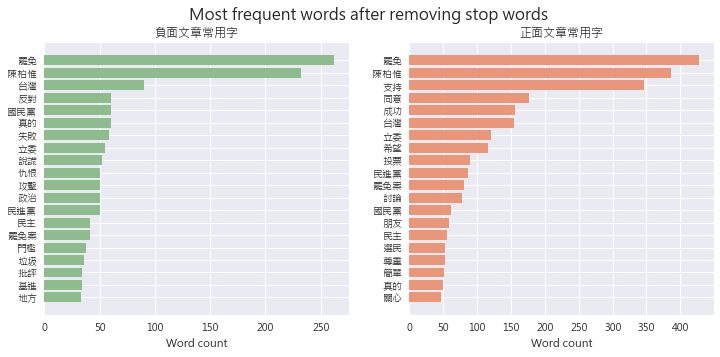

In [23]:
from matplotlib.font_manager import FontProperties

plt.figure(figsize=(12,5))   
#plt.style.use('seaborn') 
 

plt.subplot(121)
plt.title('負面文章常用字')
plt.xlabel('Word count')
plt.barh(book1['word'],book1['size'],color="darkseagreen")

plt.subplot(122)
plt.title('正面文章常用字')
plt.xlabel('Word count')
plt.barh(book2['word'],book2['size'],color="darksalmon")

# 最上面的標題
plt.suptitle('Most frequent words after removing stop words', fontsize=16)
plt.show()


負面文章常用字除了罷免陳柏惟外有反對、國民黨、失敗等

正面文章常用字除了罷免陳柏惟外有支持、同意、成功等

### 3.2 將資料切成訓練集與測試集

根據7:3的比例切分資料集


In [24]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(data_senti, stratify=data_senti["label"],
                                                       test_size=0.3, random_state=2021)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
C:\ProgramData\Anaconda3\lib\site-packages\

In [25]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data_senti['label'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['label'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['label'].value_counts(normalize=True) * 100}")

raw data percentage :
neu    77.783758
pos    12.564287
neg     9.651956
Name: label, dtype: float64

train percentage :
neu    77.778727
pos    12.567279
neg     9.653994
Name: label, dtype: float64

test percentage :
neu    77.795495
pos    12.557305
neg     9.647200
Name: label, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.3 將文章轉為 DTM


In [26]:
cv_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000)  # , ngram_range=(1,2)
cv_vectorizer_min = feature_extraction.text.CountVectorizer(max_features=10000,min_df = 10) # , ngram_range=(1,2)
corpus = dtf_train["clean_txt"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


過濾詞頻比較

In [27]:
# 沒有過濾最低詞頻的 vectorizer
cv_vectorizer.fit(corpus)
X_train = cv_vectorizer.transform(corpus)
vocabulary = cv_vectorizer.get_feature_names()

# 過濾至少要出現10次 vectorizer
cv_vectorizer_min.fit(corpus)
X_train_min = cv_vectorizer_min.transform(corpus)
vocabulary_min = cv_vectorizer_min.get_feature_names()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### logistic + vectorizer

In [28]:
# 定義分類器模型
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobyte

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy: 0.92
Auc: 0.95
Detail:
              precision    recall  f1-score   support

         neg       0.94      0.52      0.67       484
         neu       0.91      1.00      0.95      3903
         pos       0.98      0.73      0.84       630

    accuracy                           0.92      5017
   macro avg       0.94      0.75      0.82      5017
weighted avg       0.92      0.92      0.91      5017



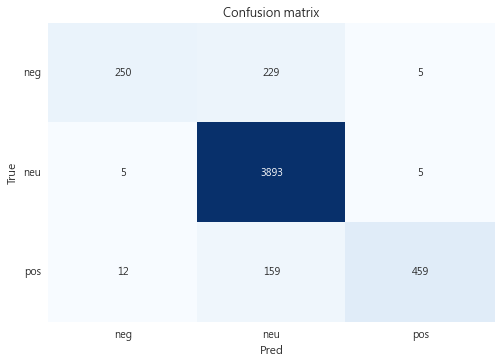

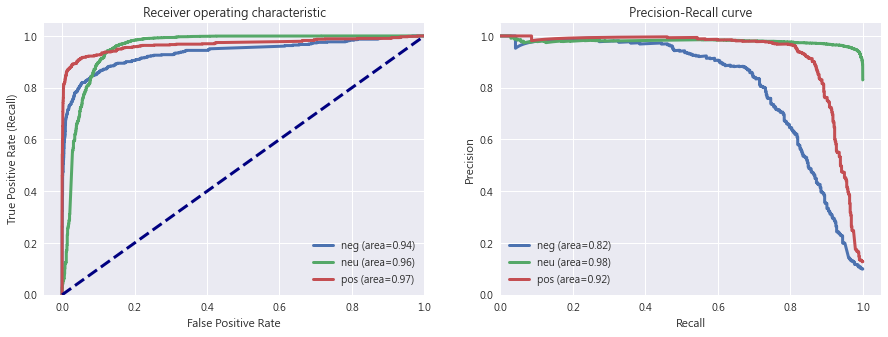

In [30]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

組合1:logistic + vectorizer，模型Accuracy為0.92、Auc為0.95，並且觀察PRcurve分類器在分類上沒有過於極端的分類情況產生。

#### logistic + vectorizer_min

In [31]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer_min),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train_min, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobyte

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy: 0.89
Auc: 0.82
Detail:
              precision    recall  f1-score   support

         neg       0.89      0.42      0.57       484
         neu       0.89      0.99      0.94      3903
         pos       0.94      0.66      0.77       630

    accuracy                           0.89      5017
   macro avg       0.91      0.69      0.76      5017
weighted avg       0.90      0.89      0.88      5017



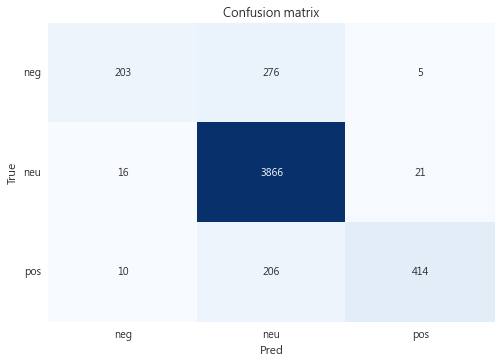

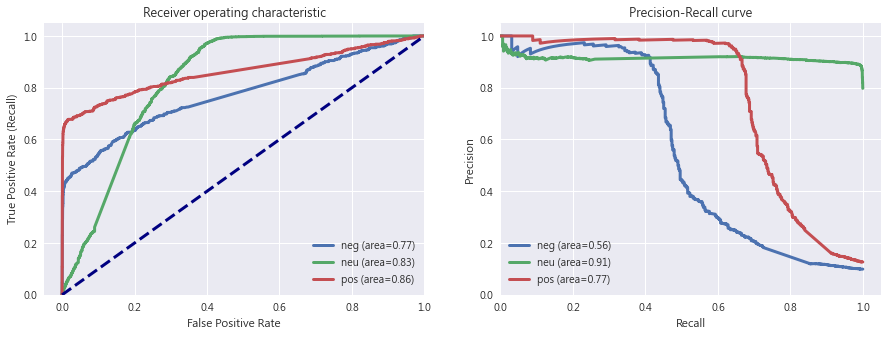

In [32]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

組合1:logistic + vectorizer_min，模型Accuracy為0.89、Auc為0.82。經過詞頻篩選的資料處理，其模型表現能力較未經過篩選差。

 定義建模與畫圖的函數

In [33]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(corpus)    
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ROC 適用二元分類，故將每個類別(正面、中性、負面情緒)的預測都視作為一個二元分類，以下比較上面各模型的分類效果
* step 1 定義 vectorizer

In [35]:
cut_off = 0 # 經由實驗發現詞頻不篩模型會比較準，但需要較長的時間，同學可以自行取捨
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


step 2 定義 classifier

In [36]:
cla_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


step 3 定義測試和訓練資料集

In [37]:
train_data = dtf_train["clean_txt"]
test_data = dtf_test["clean_txt"]
train_label = y_train
test_label = y_test

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
## 創造一個空的dataframe 和 list 存模型結果
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.4 比較不同模型和資料組合的訓練結果
####  3.4.1 Model Building : logistic regression

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model type: CV + logistic regression


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

time costing: 1.7481794357299805
Accuracy: 0.92
Auc: 0.95
Detail:
              precision    recall  f1-score   support

         neg       0.94      0.52      0.67       484
         neu       0.91      1.00      0.95      3903
         pos       0.98      0.73      0.84       630

    accuracy                           0.92      5017
   macro avg       0.94      0.75      0.82      5017
weighted avg       0.92      0.92      0.91      5017



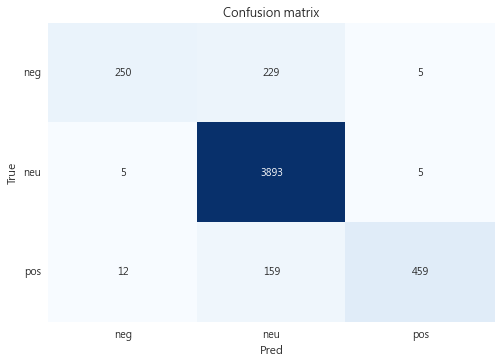

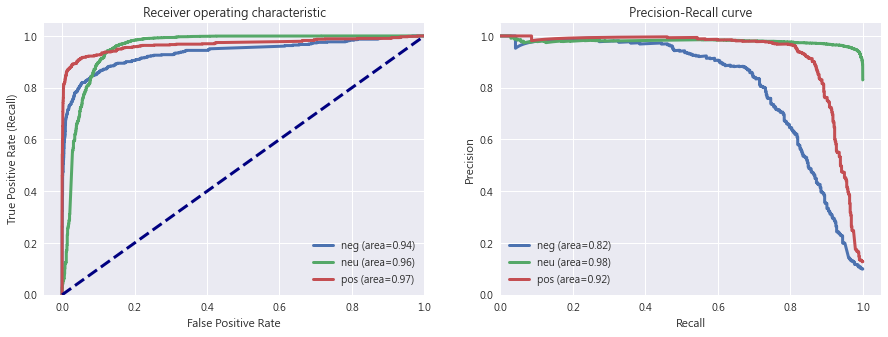

In [39]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model type: TF-IDF + logistic regression


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

time costing: 1.719616413116455
Accuracy: 0.88
Auc: 0.95
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.32      0.48       484
         neu       0.87      1.00      0.93      3903
         pos       0.99      0.56      0.71       630

    accuracy                           0.88      5017
   macro avg       0.94      0.63      0.71      5017
weighted avg       0.89      0.88      0.86      5017



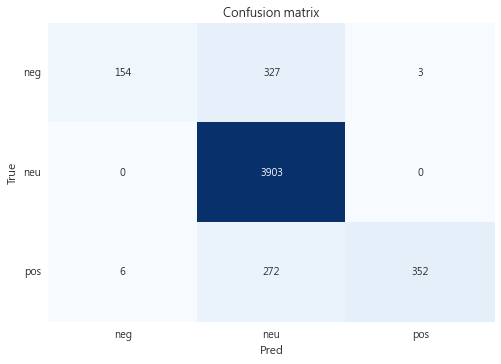

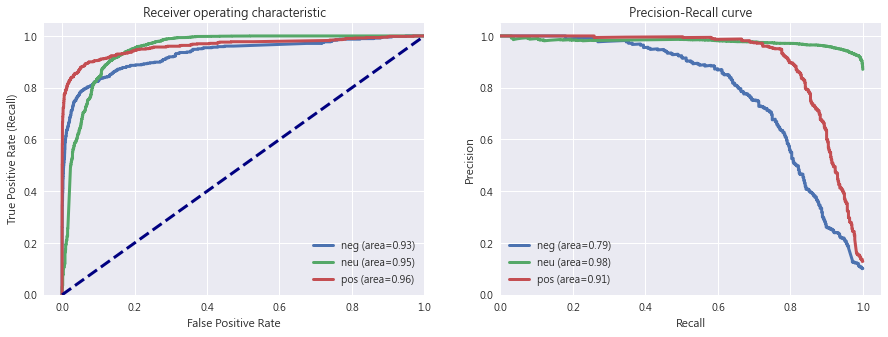

In [40]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 3.4.2 Model Building : SVC

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model type: CV + SVC
time costing: 64.58528995513916
Accuracy: 0.87
Auc: 0.95
Detail:
              precision    recall  f1-score   support

         neg       0.99      0.28      0.43       484
         neu       0.86      1.00      0.92      3903
         pos       0.99      0.52      0.68       630

    accuracy                           0.87      5017
   macro avg       0.95      0.60      0.68      5017
weighted avg       0.89      0.87      0.85      5017



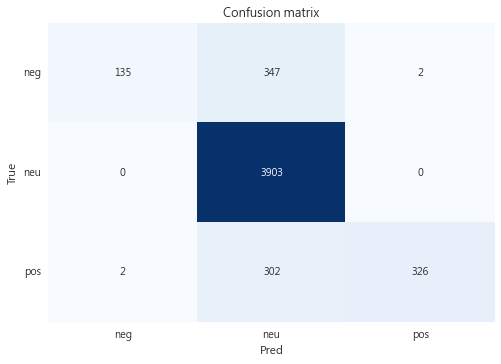

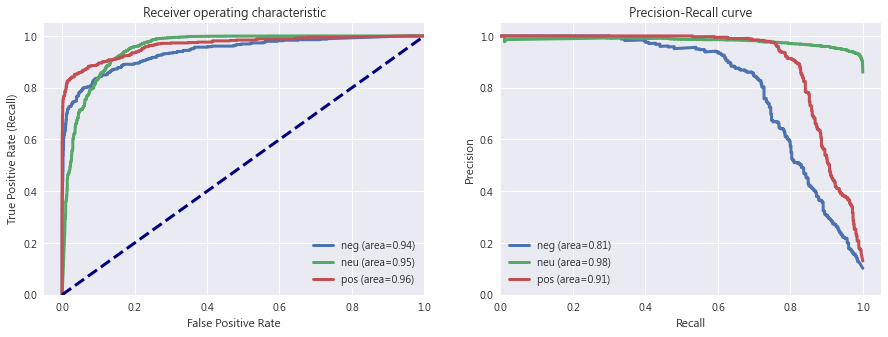

In [41]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model type: TF-IDF + SVC
time costing: 82.60034203529358
Accuracy: 0.89
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.97      0.32      0.49       484
         neu       0.87      1.00      0.93      3903
         pos       0.99      0.61      0.75       630

    accuracy                           0.89      5017
   macro avg       0.94      0.64      0.72      5017
weighted avg       0.90      0.89      0.87      5017



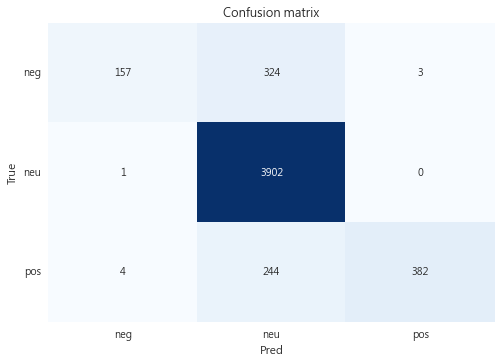

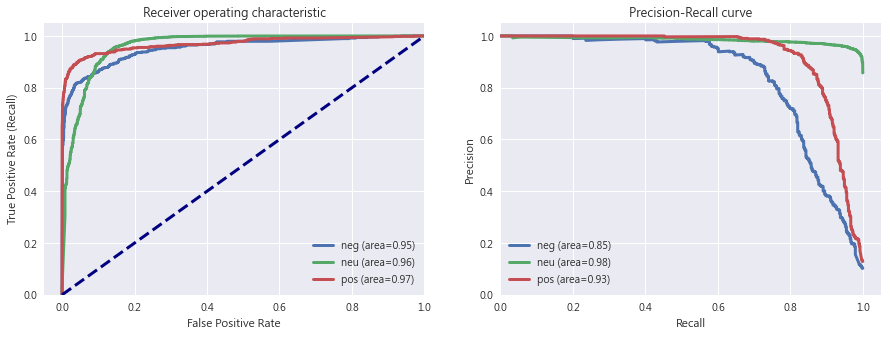

In [42]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 3.4.3 Model Building : RandomForest

model type: CV + RandomForest


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:569: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\ProgramData\

time costing: 13.07903504371643
Accuracy: 0.95
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.95      0.67      0.79       484
         neu       0.94      1.00      0.97      3903
         pos       0.98      0.83      0.90       630

    accuracy                           0.95      5017
   macro avg       0.96      0.83      0.89      5017
weighted avg       0.95      0.95      0.94      5017



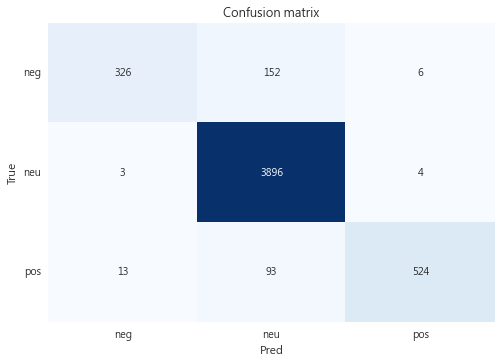

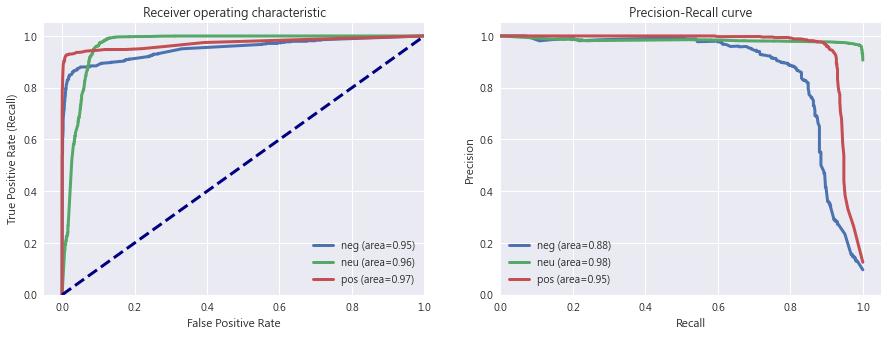

In [43]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model type: TF-IDF + RandomForest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:569: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your

time costing: 13.069632053375244
Accuracy: 0.94
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.65      0.77       484
         neu       0.93      1.00      0.97      3903
         pos       0.99      0.80      0.89       630

    accuracy                           0.94      5017
   macro avg       0.96      0.82      0.88      5017
weighted avg       0.94      0.94      0.94      5017



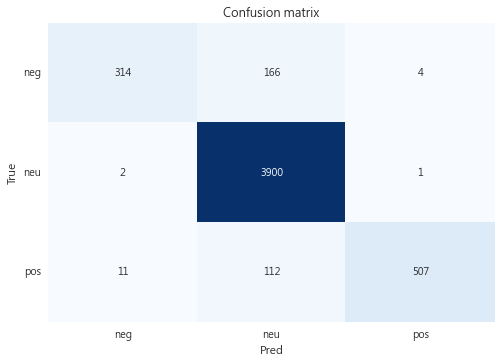

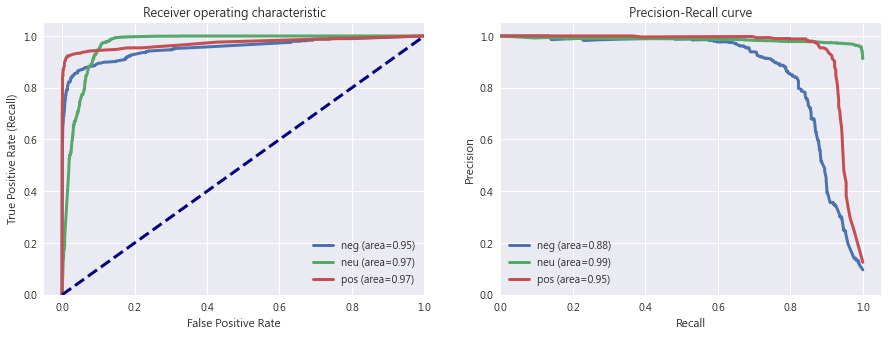

In [44]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 3.4.4 預測結果探索
* 各字詞特徵的estimate係數
* 查看分類錯誤的句子
* 比較不同模型的ROC

In [45]:
result_df.sort_values(by=['Accuracy'], ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model_type,Accuracy,AUC
4,CV + RandomForest,0.945984,0.962698
5,TF-IDF + RandomForest,0.941001,0.964192
0,CV + logistic regression,0.917281,0.952733
3,TF-IDF + SVC,0.885190,0.960741
1,TF-IDF + logistic regression,0.878812,0.945918
2,CV + SVC,0.869843,0.952133


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


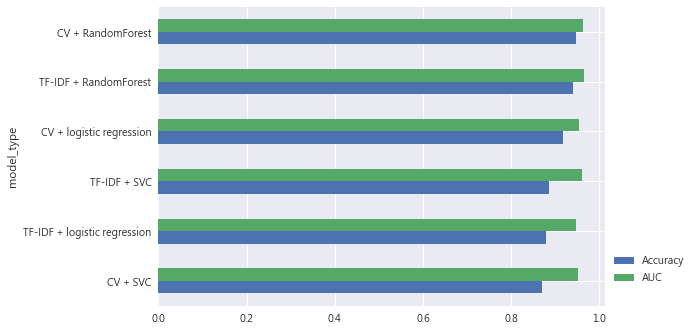

In [46]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(1,0.2))

透過ACC及AUC判斷最佳模型參數組合為'TF-IDF + RandomForest' 及 'CV + RandomForest'

各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響

In [47]:
def plot_coef(logreg_coef):    
    
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = logreg_coef[[label]].sort_values(by=label, ascending=False) \
                        .iloc[np.r_[0:top_n, -top_n:0]]    
        word = select_words.index
        count = select_words[label]        
        category_colors = np.where(select_words[label] >= 0, "darkseagreen","rosybrown") # 設定顏色
                
        fig, ax = plt.subplots(figsize =(8, 6)) # 設定畫布
        plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']  # 設定中文
        plt.rcParams['axes.unicode_minus'] = False
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title('Coeff increase/decrease odds ratio of 「'+ label +'」 label the most',
                     loc ='left', size = 16)
        ax.set_ylabel('word', size = 14)
        ax.set_xlabel('Word Frequency', size = 14)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names()

# logisticRegr 是 5.1 存起來的模型
classes = logisticRegr.classes_ # 分類label
log_odds = logisticRegr.coef_.reshape(len(vocabulary),len(classes)) # 字詞係數
coef_df = pd.DataFrame(
                     log_odds, # value 字詞
                     vocabulary, # row 詞彙
                     columns = classes)  # column 是類別
coef_df.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,neg,neu,pos
一一,-0.099897,0.199579,-0.076770
一下子,-0.032321,-0.036273,-0.037121
一丘之貉,-0.098552,-0.024908,-0.364911
一中,-0.028339,-0.002837,0.156812
一串,-0.062243,0.117593,0.355948


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


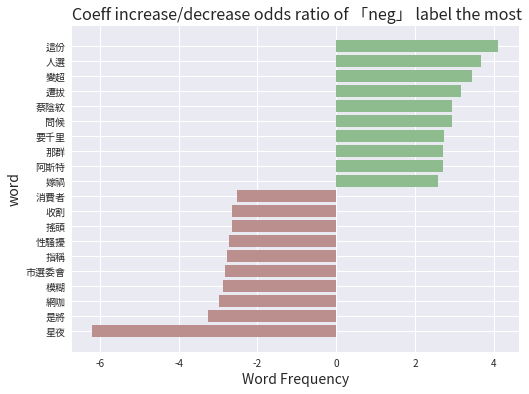

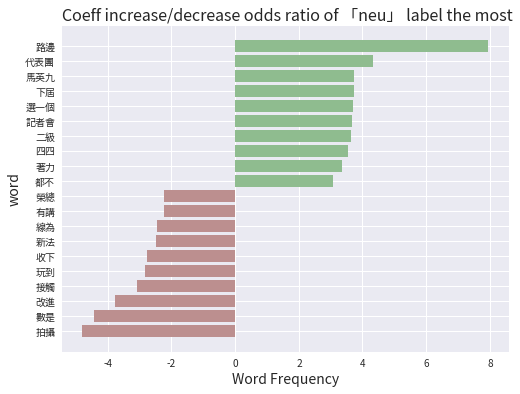

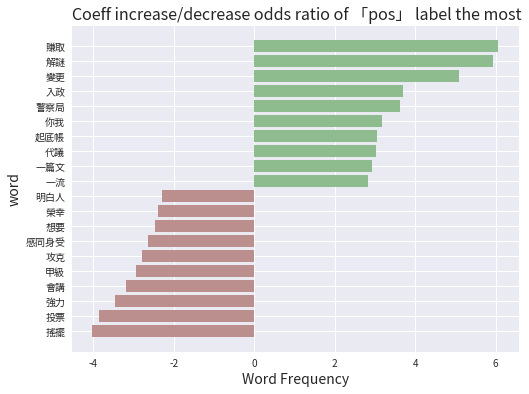

In [49]:
# 把前10大影響力的字詞畫出來
plot_coef(coef_df)

In [50]:
keyword_list = ['3q','罷免','同意票'] 
data_senti[data_senti['sentence'].str.contains('|'.join(keyword_list),regex=True)][['document','sentence','artUrl','label']] \
                                .head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,document,sentence,artUrl,label
0,0,問卦總統我投票選的想罷免我要聽立委的,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,neu
1,1,很簡單啊先把立委都罷免掉,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,pos
2,2,等罷到可以罷免總統程度的時侯,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,neu
3,3,再把總統罷免掉不就好了,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,neu
27,27,台灣基進立委陳柏惟罷免案投票將於日登場台灣社等多個台灣本土社團今天發表聯合,https://www.ptt.cc/bbs/Gossiping/M.1633660380....,neu
33,33,台灣社質疑觀察他們罷免理由無一不是編造謊言抹黑誣衊,https://www.ptt.cc/bbs/Gossiping/M.1633660380....,neu
60,60,同的未來利益和前途請排除萬難前往投票所踴躍投下您反對罷免的一票將顏家,https://www.ptt.cc/bbs/Gossiping/M.1633660380....,neg
93,93,看到陳柏惟被罷免案進入第三節段顏寬恆的心理是怎麼想呢,https://www.ptt.cc/bbs/HatePolitics/M.16261134...,neu
94,94,他會希望陳柏惟被罷免掉然後自己要花錢來選個任期剩一半的立委嗎,https://www.ptt.cc/bbs/HatePolitics/M.16261134...,pos
96,96,如果陳柏惟最後沒被罷免掉會不會反而讓他的聲勢更高,https://www.ptt.cc/bbs/HatePolitics/M.16261134...,neu


查看分類錯誤的句子

In [51]:
# 把預測的值加回去
dtf_test['predict'] = pred
pos_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'pos')] # 正面句子分錯
neg_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neg')] # 負面句子分錯
neu_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neu')] # 中性句子分錯

print(f"pos label predicted wrong: {pos_wrong.shape[0]}")
print(f"neg label predicted wrong: {neg_wrong.shape[0]}")
print(f"neu label predicted wrong: {neu_wrong.shape[0]}")

pos label predicted wrong: 123
neg label predicted wrong: 170
neu label predicted wrong: 3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
# 正面句子分錯
pos_wrong[['sentence','artUrl','label','predict']].head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sentence,artUrl,label,predict
2389,凌濤指出這場罷免並不是政治攻防而是要捍衛社會秩序找回善良與正直的道德保衛,https://www.ptt.cc/bbs/Gossiping/M.1634015303....,pos,neu
15316,當初王浩宇也被評比為優良啊,https://www.ptt.cc/bbs/HatePolitics/M.16161465...,pos,neu
87,有沒有想對說一句鼓勵的話,https://www.ptt.cc/bbs/HatePolitics/M.16349031...,pos,neu
2484,至願意選擇逗趣創新的您擔任本區的立法委員寬恒一直以為這將會是一段佳話未來大,https://www.ptt.cc/bbs/HatePolitics/M.16310950...,pos,neu
2833,這做法的優點是,https://www.ptt.cc/bbs/Gossiping/M.1634993984....,pos,neu


In [53]:
# 負面句子分錯
neg_wrong[['sentence','artUrl','label','predict']].head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sentence,artUrl,label,predict
10832,乾脆說台灣人不准罷免塔綠班的政客好了啊,https://www.ptt.cc/bbs/Gossiping/M.1635004038....,neg,neu
3744,這個年輕人有過惡劣的紀錄,https://www.ptt.cc/bbs/HatePolitics/M.16349136...,neg,neu
11758,到底最大的過錯在哪裡,https://www.ptt.cc/bbs/Gossiping/M.1632897578....,neg,neu
12782,的確在罷免投票日前陳柏惟的表現得很幼稚但這不是政策上的幼稚正好相反這,https://www.ptt.cc/bbs/Gossiping/M.1632881894....,neg,neu
2496,您花了很多功夫開記者會指控掃地機器人偷竊民眾家中資料回傳中共卡通頻道的動畫被,https://www.ptt.cc/bbs/HatePolitics/M.16310950...,neg,neu


In [54]:
# 中性句子分錯
neu_wrong[['sentence','artUrl','label','predict']].head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sentence,artUrl,label,predict
3673,大家覺得為什麼不修改呢,https://www.ptt.cc/bbs/HatePolitics/M.16347327...,neu,neg
4830,啊幹你們的台獨精神跑哪去,https://www.ptt.cc/bbs/Gossiping/M.1634309837....,neu,neg
12196,陳吉仲叫肥迪快講話,https://www.ptt.cc/bbs/HatePolitics/M.16254198...,neu,pos


#### 3.4.5 比較不同模型的ROC

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


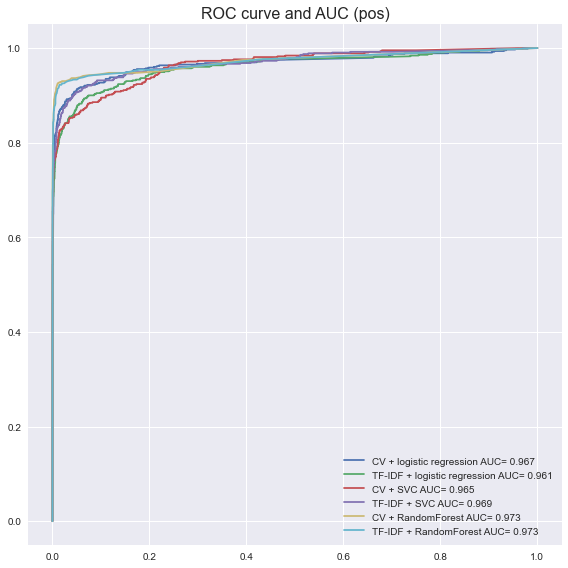

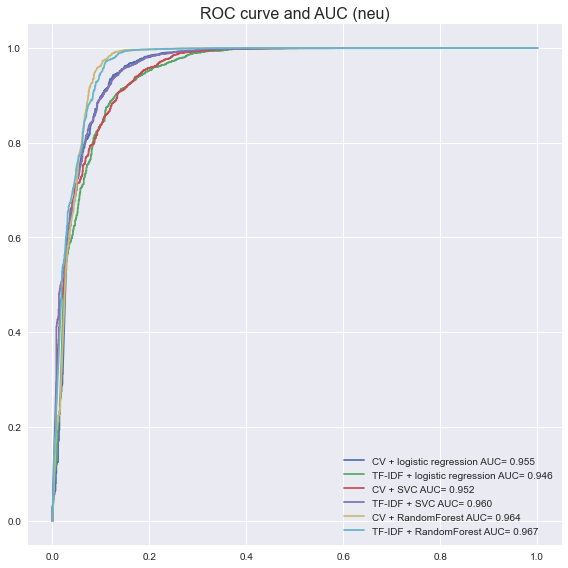

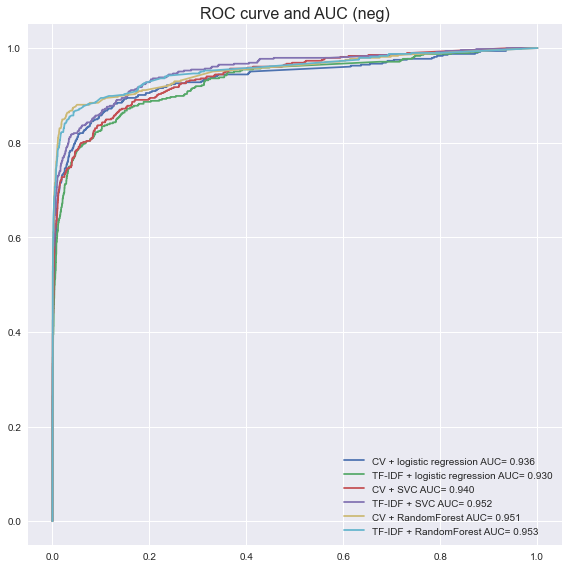

In [55]:
plt.style.use('seaborn')    

l = ['pos','neu','neg']
for label in l:
    plt.figure(figsize =(8, 8))
    for k, v in roc_auc_all.items():
        fpr = roc_auc_all[k][label]["fpr"]
        tpr = roc_auc_all[k][label]["tpr"]
        roc_auc = roc_auc_all[k][label]["roc_auc"]
        plt.plot(fpr,tpr,label= k + " AUC= %0.3f" % roc_auc)
        plt.title('ROC curve and AUC ('+ label +')', size = 16)    
    plt.legend(loc=0)
    plt.tight_layout()

綜合來說在三個類別的模型表現上以'CV + RandomForest'表現最佳，其次為 'TF-IDF +RandomForest'

## 4. LDA 主題模型


In [56]:
metadata['sentence'] = metadata.sentence.apply(lambda x: re.sub('(完整內容|新聞|新聞網址|新聞來源|媒體來源|記者署名|網址來源|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
metadata['sentence'] = metadata.sentence.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))
metadata['sentence'] = metadata.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',str(x)))
metadata['sentence'] = metadata.sentence.apply(lambda x: re.sub('\\n{1,2}', ',', x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
# 資料進行斷詞，為list的格式
data = metadata[['artUrl','sentence']]
token_df = data.assign(wordlist = data['sentence'].astype(str).apply(jieba.lcut))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
stopwords = []

#匯入檔案
with open(f'./dict/stopwords.txt','r',encoding='utf-8') as f:
    stopwords = f.read().splitlines() #移除換行符號\n


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
# 移除停用字的 function
def remove_stop(listt):
    result = [re.sub(r'\d|-', '', word) for word in listt]
    result = [word for word in result if len(word)>1] 
    result = list(filter(lambda x : x not in stopwords, result)) 
    return result

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
# list 刪掉 stopwords
token_df = token_df.assign( remove_stopwords = token_df['wordlist'].apply(remove_stop))
print("remove_stopwords 為 wordlist 移除停用字後的結果：")
token_df.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


remove_stopwords 為 wordlist 移除停用字後的結果：


,artUrl,sentence,wordlist,remove_stopwords
0,https://www.ptt.cc/bbs/Gossiping/M.1622218635....,很簡單啊先把立委都罷免掉等罷到可以罷免總統程度的時侯再把總統罷免掉不就好了本肥是不是很聰明,"[很, 簡單, 啊, 先, 把, 立委, 都, 罷免, 掉, 等, 罷到, 可以, 罷免, ...","[簡單, 立委, 罷免, 罷到, 罷免, 總統, 程度, 時侯, 總統, 罷免, 好了, 本..."
1,https://www.ptt.cc/bbs/Gossiping/M.1634030006....,是這樣的陳伯唯到爸爸的賭場裡面打快打旋風還輸了一千陳伯唯確實好孝可能他的孝親費都是習慣這樣給...,"[是, 這樣, 的, 陳伯, 唯到, 爸爸, 的, 賭場, 裡面, 打, 快打旋風, 還輸,...","[陳伯, 唯到, 爸爸, 賭場, 快打旋風, 還輸, 了一, 陳伯, 確實, 孝親費, 都是..."
2,https://www.ptt.cc/bbs/Gossiping/M.1633694167....,如果家裡是開賭博間那等於就是做莊嘛賭博間做莊通常就穩賺不賠了所以不能算低層請修正,"[如果, 家裡, 是, 開, 賭博, 間, 那, 等於, 就是, 做莊, 嘛, 賭博, 間,...","[家裡, 賭博, 等於, 做莊, 賭博, 做莊, 穩賺, 低層, 修正]"


###  4.1 訓練 LDA 模型

* 將文章斷詞結果儲存為 list 資料形態，一篇文章為一個 list ，其中 element 為詞彙。

In [61]:
token_data = token_df['remove_stopwords'].tolist()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
for i in range(0,3):
    print("第 " + str(i+1) + " 篇文章前5個字：")
    for j in range(0,5):
        print(token_data[i][j], end=' ')
    print('\n')

第 1 篇文章前5個字：
簡單 立委 罷免 罷到 罷免 

第 2 篇文章前5個字：
陳伯 唯到 爸爸 賭場 快打旋風 

第 3 篇文章前5個字：
家裡 賭博 等於 做莊 賭博 



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id2word 將斷詞結果生成字典，裡頭為資料集裡出現的字。

In [63]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(15329 unique tokens: ['好了', '時侯', '本肥', '程度', '立委']...)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 3), (8, 1), (9, 1)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


參數說明：

* corpus = 文檔語料庫
* id2word = 詞彙字典
* num_topics = 生成幾個主題數
* random_state = 固定亂數值，每次的模型結果會一樣
* iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
* passes(epoch) = 整個 corpus 訓練模型的次數
* alpha = 文章主題分佈
* eta = 主題字分佈

In [65]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=1005, # 亂數
    iterations = 1000,
    passes=5, # 模型訓練次數
)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 4.2 查看 LDA 主題代表字


In [66]:
# 每個主題重要的前五個關鍵字
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.032*"罷免" + 0.009*"陳柏惟" + 0.006*"門檻" + 0.006*"民進黨" + 0.005*"立委"')
(1, '0.020*"陳柏惟" + 0.017*"罷免" + 0.015*"台灣" + 0.009*"立委" + 0.007*"國民黨"')
(2, '0.022*"陳柏惟" + 0.016*"罷免" + 0.010*"立委" + 0.006*"民進黨" + 0.006*"支持"')
(3, '0.012*"陳柏惟" + 0.010*"罷免" + 0.007*"台灣" + 0.006*"立委" + 0.006*"民進黨"')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


若區分成4個主題判斷討論內容

主題1 : 談論罷免門檻

主題2 : 談論國民黨

主題3 : 談論民進黨支持陳伯惟

主題4 : 談論民進黨與台灣價值

### 4.3 查看 LDA 模型指標


In [67]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


這個主題的 PMI score:  -0.8831547299622454


In [68]:
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


這個主題的 Perplexity Score:  -8.672043375217875


### 4.4 透過指標找出最佳主題數

In [69]:
topic_num_list = np.arange(2, 10, 2)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_num,gensim_perplexity,perplexity
0,2,-8.617825,5529.348924
1,4,-8.667007,5808.088326
2,6,-8.702107,6015.572917
3,8,-8.721635,6134.202610


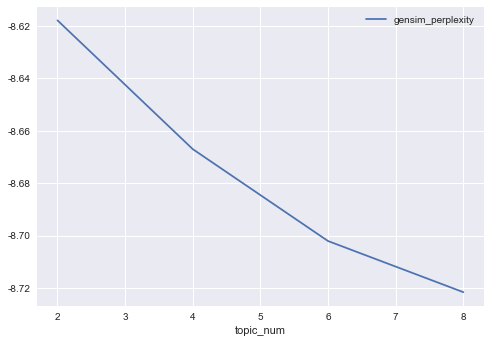

In [70]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_num,gensim_perplexity,perplexity
0,2,-8.617825,5529.348924
1,4,-8.667007,5808.088326
2,6,-8.702107,6015.572917
3,8,-8.721635,6134.202610


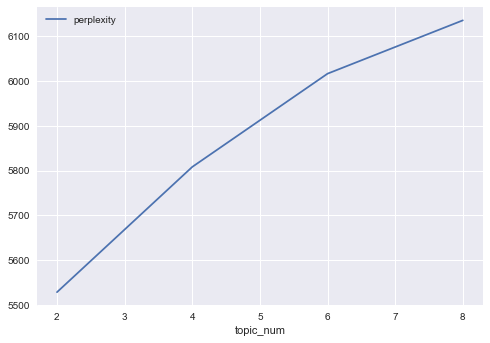

In [71]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

由上可知主題數為2為最佳topic_num

In [72]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=2, # 生成幾個主題數
    random_state=1005, # 亂數
    iterations = 1000,
    passes=5, # 模型訓練次數
)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
# 每個主題重要的前五個關鍵字
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.025*"罷免" + 0.009*"陳柏惟" + 0.006*"民進黨" + 0.005*"立委" + 0.004*"真的"')
(1, '0.022*"陳柏惟" + 0.015*"罷免" + 0.012*"台灣" + 0.010*"立委" + 0.006*"國民黨"')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


主題數為2期談論的內容分別為

主題1 : 民進黨與罷免事件

主題2 : 國民黨與罷免事件

### 4.5 視覺化呈現
#### 4.5.1 產生 LDAvis 結果


In [74]:
#生成模型 
ldamodel2 = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=2, # 生成幾個主題數
    random_state=2500, # 亂數
    iterations = 2000,
    passes=5, # 模型訓練次數
)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel2, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'./ldaVis.html')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [76]:
# 取得每條新聞的主題分佈
topics_doc = ldamodel2.get_document_topics(corpus)  

# 將結果列成list
doc_list = []

# topics_doc[i] 為第一個文章
for i in range(0,len(topics_doc)):

    # 都先假定第一個主題為最大的
    max_freq = topics_doc[i][0][1]
    max_topic = topics_doc[i][0][0]

    # 後面假如有比較大的就取代
    for j in topics_doc[i]:
        if(j[1] > max_freq):
            max_freq = j[1]
            max_topic = j[0]

    doc_list.append(max_topic)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
# 將結果放進 DataFrame裏
metadata['topic'] = doc_list

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
# 將 artDate 轉換為 Python 日期時間
metadata.artDate = pd.to_datetime(metadata['artDate'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':metadata.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
# date_topic.artDate.dt.to_period('M')：把日期按月份形式表示
date_topic = date_topic.groupby([date_topic.artDate.dt.to_period('M'),'topic']).sum().reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1']
# 前面日期變period形式要把他變回timestamp形式 --> to_timestamp：以便於畫圖
date_df = date_df.set_index('artDate').to_timestamp()
date_df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic0,topic1
artDate,,
2021-03-01,34,23
2021-04-01,8,5
2021-05-01,31,13
2021-06-01,12,8
2021-07-01,13,9
2021-08-01,16,10
2021-09-01,36,31
2021-10-01,431,320


In [81]:
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1 

for i in range(0,2):
    ratio_df['topic'+str(i)] = ratio_df['topic'+str(i)] / ratio_df['sum']

ratio_df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic0,topic1,sum
artDate,,,
2021-03-01,0.596491,0.403509,57
2021-04-01,0.615385,0.384615,13
2021-05-01,0.704545,0.295455,44
2021-06-01,0.600000,0.400000,20
2021-07-01,0.590909,0.409091,22
2021-08-01,0.615385,0.384615,26
2021-09-01,0.537313,0.462687,67
2021-10-01,0.573901,0.426099,751


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 27599 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 31456 missin

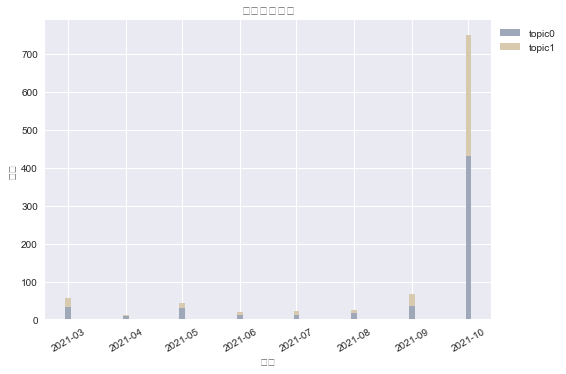

In [82]:
color = ["#9FA8B9", "#D8CAAF"]
column = ['topic0', 'topic1']
temp_bottom = 0

for i in range(0,2):
    if(i>0):
        temp_bottom = temp_bottom + date_df[column[i-1]]
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i] , width=3)
    else: # 主題一 bottom 為 0
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], label=column[i] , width=3)
        

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

#### 4.5.2 資料內容探索
 * 查看兩個主題的內容

In [83]:
metadata[["artTitle","topic"]].head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,artTitle,topic
0,Re:[問卦]總統我投票選的，想罷免我要聽立委的？,0
1,Re:[新聞]徒步100小時被酸？3Q：孝順的人怎麼會罷,0
2,Re:[新聞]陳柏惟曾自爆「從小在賭場長大」周玉蔻：,1
3,Re:[新聞]陳柏惟苦行第四日腳傷又體力透支兩度跌,1
4,[新聞]本土社團力挺陳柏惟台灣社：國民黨展開,1


In [84]:
metadata[(metadata["topic"]==0)&(metadata["artTitle"].str.contains("罷免"))][["artTitle","topic"]].sample(n=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,artTitle,topic
483,[新聞]影／范雲：中共下指導棋內外夾攻要罷免,0
175,[問卦]改成選舉沒投候選人，就不能投罷免如何,0
13,Re:[新聞]陳柏惟坦言投完不同意罷免掛急診,0
361,[黑特]菸粉抱怨KMT不分區議員又沒膽罷免,0
327,[討論]罷免大概會失敗,0


In [85]:
metadata[(metadata["topic"]==1)&(metadata["artTitle"].str.contains("陳柏惟"))][["artTitle","topic"]].sample(n=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,artTitle,topic
84,Re:[新聞]陳柏惟質詢稱「台北是最大中國城」 議員,1
27,[討論]陳柏惟ok黃國書不ok,1
973,Re:[新聞]陳柏惟又因台語起爭議：阿公阿嬤聽不懂怎,1
799,Re:[新聞]阿北現身！陳柏惟曾撞傷他肇逃 鄰轟：年,1
346,Re:[新聞]傳曾經肇事逃逸？陳柏惟認了：不好意思,1


畫出每日主題分布

In [86]:
# 轉換artDate為 Python 日期格式
metadata['artDate'] = pd.to_datetime(metadata['artDate'], format="%Y-%m-%d")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':metadata.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
date_topic

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,artDate,topic,count
0,2021-03-05,0,1
1,2021-03-06,0,1
2,2021-03-06,1,2
3,2021-03-09,0,1
4,2021-03-10,0,1
...,...,...,...
183,2021-10-29,0,3
184,2021-10-29,1,4
185,2021-10-30,0,3
186,2021-10-30,1,2


In [88]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1']
date_df = date_df.set_index('artDate')
date_df=date_df[-10:-5]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 31456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 31687 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 25976 missin

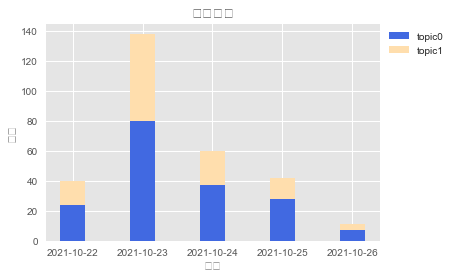

In [89]:
plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

ind = np.arange(5)    
width = 0.35       

plt.bar(ind, date_df["topic0"], width, label="topic0",color='royalblue')
plt.bar(ind, date_df["topic1"], width,  bottom=date_df["topic0"], label="topic1",color='navajowhite')

plt.xticks(ind, ('2021-10-22', '2021-10-23', '2021-10-24','2021-10-25','2021-10-26'))
plt.title('文章篇數') # 標題
plt.xlabel('日期') # x軸標題
plt.ylabel('篇數') # y軸標題
# plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置

plt.show()

以日期來看，討論主題1或主題2的文章數量差異不大

In [90]:
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1  

for i in range(0,2):
    ratio_df['topic'+str(i)] = ratio_df['topic'+str(i)] / ratio_df['sum']

ratio_df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic0,topic1,sum
artDate,,,
2021-10-22,0.600000,0.400000,40.0
2021-10-23,0.579710,0.420290,138.0
2021-10-24,0.616667,0.383333,60.0
2021-10-25,0.666667,0.333333,42.0
2021-10-26,0.636364,0.363636,11.0


## 5.社群網路圖
社群網絡分析就是運用圖論(Graph theory)從這些節點和連結去研究人與人之間的關係以及整個群體的結構

### 5.1 基本網路圖

In [91]:
Reviews_gossip = pd.read_csv('Data/bowei_gossip２_articleReviews.csv')
Reviews_hatepolitic = pd.read_csv('Data/bowei_HatePolitics_articleReviews.csv')
Reviews = pd.concat([Reviews_gossip,Reviews_hatepolitic],axis=0).reset_index() 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
# 把reviews中 cmtPoster(回覆者), cmtStatus(推噓), cmtContent(留言) 合併到 metadata的資料表
posts_Reviews = Reviews.loc[:,["artUrl", "cmtPoster", "cmtStatus", "cmtContent"]]
posts_Reviews  = pd.merge(metadata, posts_Reviews, how="right", on="artUrl")
posts_Reviews = posts_Reviews[posts_Reviews["commentNum"]>0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
posts_Reviews.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,content,topic,cmtPoster,cmtStatus,cmtContent
1985,15.0,[新聞]林飛帆：不樂見罷免被濫用盼民主回到正,2021-03-06,11:55:30,https://www.ptt.cc/bbs/Gossiping/M.1615031733....,DustToDust,Gossiping,231.0,33.0,131.0,中央社溫貴香林飛帆不樂見罷免被濫用盼民主回到正軌中央社記者溫貴香台北日電罷免台灣基進立委陳柏...,[新聞]林飛帆：不樂見罷免被濫用盼民主回到正備註請放最後面 違者新聞文章刪除\n\n1.媒體...,1.0,snow3804,→,:真香
1986,15.0,[新聞]林飛帆：不樂見罷免被濫用盼民主回到正,2021-03-06,11:55:30,https://www.ptt.cc/bbs/Gossiping/M.1615031733....,DustToDust,Gossiping,231.0,33.0,131.0,中央社溫貴香林飛帆不樂見罷免被濫用盼民主回到正軌中央社記者溫貴香台北日電罷免台灣基進立委陳柏...,[新聞]林飛帆：不樂見罷免被濫用盼民主回到正備註請放最後面 違者新聞文章刪除\n\n1.媒體...,1.0,Neisseria,推,:離個題。新南向在台灣冬令營是什麼神活動？
1987,15.0,[新聞]林飛帆：不樂見罷免被濫用盼民主回到正,2021-03-06,11:55:30,https://www.ptt.cc/bbs/Gossiping/M.1615031733....,DustToDust,Gossiping,231.0,33.0,131.0,中央社溫貴香林飛帆不樂見罷免被濫用盼民主回到正軌中央社記者溫貴香台北日電罷免台灣基進立委陳柏...,[新聞]林飛帆：不樂見罷免被濫用盼民主回到正備註請放最後面 違者新聞文章刪除\n\n1.媒體...,1.0,FAYeeeeeeee,→,:濫用不就新潮流開始的
1988,15.0,[新聞]林飛帆：不樂見罷免被濫用盼民主回到正,2021-03-06,11:55:30,https://www.ptt.cc/bbs/Gossiping/M.1615031733....,DustToDust,Gossiping,231.0,33.0,131.0,中央社溫貴香林飛帆不樂見罷免被濫用盼民主回到正軌中央社記者溫貴香台北日電罷免台灣基進立委陳柏...,[新聞]林飛帆：不樂見罷免被濫用盼民主回到正備註請放最後面 違者新聞文章刪除\n\n1.媒體...,1.0,k4653,→,:我也不樂見9萬被濫用啊...
1989,15.0,[新聞]林飛帆：不樂見罷免被濫用盼民主回到正,2021-03-06,11:55:30,https://www.ptt.cc/bbs/Gossiping/M.1615031733....,DustToDust,Gossiping,231.0,33.0,131.0,中央社溫貴香林飛帆不樂見罷免被濫用盼民主回到正軌中央社記者溫貴香台北日電罷免台灣基進立委陳柏...,[新聞]林飛帆：不樂見罷免被濫用盼民主回到正備註請放最後面 違者新聞文章刪除\n\n1.媒體...,1.0,Sougetu,→,:那先罷免你


In [94]:
# 取出 cmtPoster(回覆者)、artPoster(發文者)、artUrl(文章連結) 三個欄位
link = posts_Reviews.loc[:,["cmtPoster", "artPoster", "artUrl"]].reset_index(drop=True)
link.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cmtPoster,artPoster,artUrl
0,snow3804,DustToDust,https://www.ptt.cc/bbs/Gossiping/M.1615031733....
1,Neisseria,DustToDust,https://www.ptt.cc/bbs/Gossiping/M.1615031733....
2,FAYeeeeeeee,DustToDust,https://www.ptt.cc/bbs/Gossiping/M.1615031733....
3,k4653,DustToDust,https://www.ptt.cc/bbs/Gossiping/M.1615031733....
4,Sougetu,DustToDust,https://www.ptt.cc/bbs/Gossiping/M.1615031733....


In [95]:
len(link)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


52685

In [96]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,100):
    G.add_edge(link["cmtPoster"][i], link["artPoster"][i])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


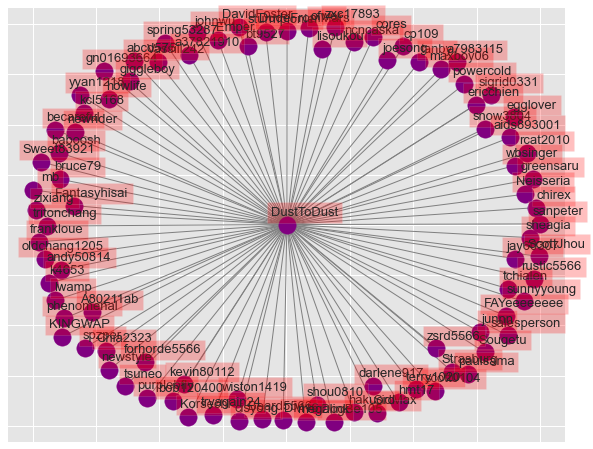

In [97]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
#                  width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045 #調整label的位置(右上)
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

### 5.2 資料篩選

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'count')

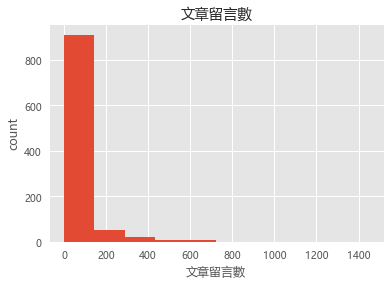

In [98]:
plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.hist(metadata["commentNum"])
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  #使中文能正常顯示
plt.title('文章留言數')
plt.xlabel('文章留言數')
plt.ylabel('count')

大多數留言數為200以下

In [99]:
# 帳號發文篇數
pd.DataFrame(metadata.groupby("artPoster").size(),columns = ['count']).reset_index().sort_values(by="count",ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,artPoster,count
473,omanorboyo,18
145,aaaba,12
83,Makubex82,11
616,venson,9
6,AZTEC,8
...,...,...
316,harkk2001,1
315,happytowork,1
102,Roorhsiao,1
313,hamsters56,1


In [100]:
# 檢視人數
print("發文者數量總共:",len(set(posts_Reviews["artPoster"])))
print("回覆者數量總共:",len(set(posts_Reviews["cmtPoster"])))

發文者數量總共: 666
回覆者數量總共: 11413


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
# 用set()得到不重複的集合
s = set(list(posts_Reviews["artPoster"])+list(posts_Reviews["cmtPoster"]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
allPoster = pd.DataFrame(list(s),columns=["user"])
allPoster

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,user
0,wizardfizban
1,Peter911
2,unformat
3,loveapple33
4,gisasy001
...,...
11707,hulu63
11708,almostreal
11709,cpkjacky
11710,TsukimiyaAyu


In [103]:
allPoster["type"] = allPoster["user"].apply(lambda x: "poster" if x in list(metadata["artPoster"]) else "replayer")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
allPoster.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,user,type
0,wizardfizban,poster
1,Peter911,replayer
2,unformat,replayer
3,loveapple33,replayer
4,gisasy001,replayer


### 5.3 以日期篩選社群

In [105]:
# 篩選日期為2021-05-22 且 留言數>200的
posts_Reviews_0522 = (posts_Reviews.query('artDate > "2021-10-22"')
                      .query('commentNum>200')
                      .groupby(['cmtPoster','artUrl'],as_index=False).size()
                     )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
# 篩選有人在同一篇文章重複回覆大於5次
posts_Reviews_0522 = posts_Reviews_0522.query('size>5')
posts_Reviews_0522.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cmtPoster,artUrl,size
67,Atkins13,https://www.ptt.cc/bbs/HatePolitics/M.16349991...,38
153,CYL009,https://www.ptt.cc/bbs/HatePolitics/M.16350814...,8
169,ChangWufei,https://www.ptt.cc/bbs/Gossiping/M.1634988495....,6


In [107]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_0522 = pd.merge(posts_Reviews_0522,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_0522.reset_index(inplace=True, drop=True) #重設index
link_0522.head(3)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cmtPoster,artUrl,size,artPoster
0,Atkins13,https://www.ptt.cc/bbs/HatePolitics/M.16349991...,38,ysb727
1,CYL009,https://www.ptt.cc/bbs/HatePolitics/M.16350814...,8,Neptunium
2,ChangWufei,https://www.ptt.cc/bbs/Gossiping/M.1634988495....,6,jk182325


In [108]:
# Create network plot 
# nx.Graph()為無向圖 ; nx.DiGraph()為有向圖
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,len(link_0522)):
    G.add_edge(link_0522["cmtPoster"][i], link_0522["artPoster"][i])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


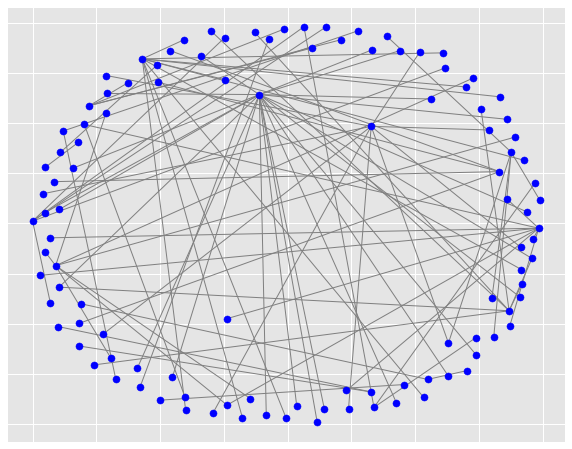

In [109]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color="blue",
                 with_labels = False,
                 ax=ax)
    
plt.show()

加上nodes的顯示資訊
用使用者的身份來區分點的顏色

poster:red(有發文)
replyer:blue(只有回覆文章)

In [110]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


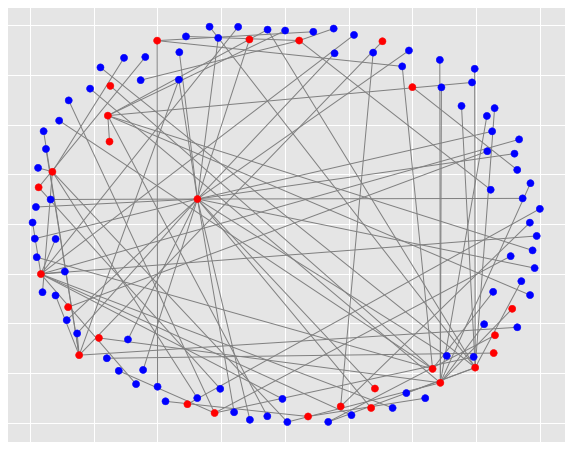

In [111]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)
    
plt.show()

In [112]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [113]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['ysb727', 'Neptunium', 'TheoEpstein', 'Aliensoul', 'william8403', 'birdjack']

In [114]:
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


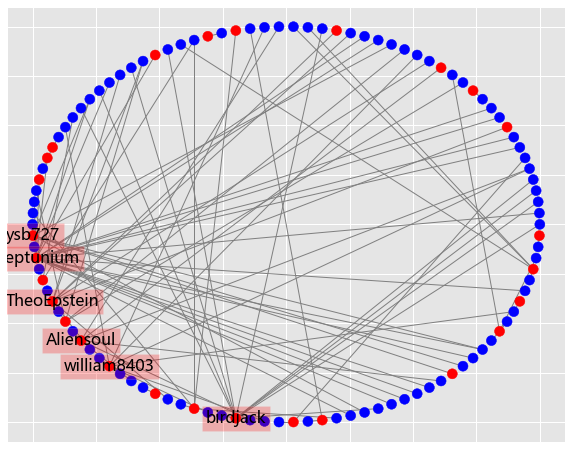

In [116]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
# pos = nx.spring_layout(G, k=2)
pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=100,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

計算Centrality
找出重要的點

In [117]:
# degree centrality
degree = nx.degree_centrality(G)
degree

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Atkins13': 0.009174311926605505,
 'ysb727': 0.08256880733944955,
 'CYL009': 0.009174311926605505,
 'Neptunium': 0.2018348623853211,
 'ChangWufei': 0.009174311926605505,
 'jk182325': 0.027522935779816515,
 'Crazyfire': 0.009174311926605505,
 'TheoEpstein': 0.10091743119266056,
 'Currahee52': 0.009174311926605505,
 'junior020486': 0.045871559633027525,
 'Galm': 0.009174311926605505,
 'Aliensoul': 0.06422018348623854,
 'Gneisenau': 0.009174311926605505,
 'HolmesBear': 0.009174311926605505,
 'william8403': 0.08256880733944955,
 'IY1227': 0.009174311926605505,
 'Jerry469': 0.009174311926605505,
 'KIKK': 0.009174311926605505,
 'Caress': 0.009174311926605505,
 'MVPGGYY': 0.009174311926605505,
 'MsKing': 0.009174311926605505,
 'm0936306306': 0.045871559633027525,
 'NTUHandsome': 0.009174311926605505,
 'NinJa': 0.009174311926605505,
 'birdjack': 0.10091743119266056,
 'Retangle': 0.009174311926605505,
 'TZUYIC': 0.009174311926605505,
 'Vyseus': 0.009174311926605505,
 'linhsiuwei': 0.0183486238

In [118]:
# eigenvector centrality
eigenvector = nx.eigenvector_centrality(G)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
# pagerank centrality
pr = nx.pagerank(G, alpha=0.9)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
# betweenness centrality
between = nx.betweenness_centrality(G)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [121]:
# 找出degree centrality最高的前5名
print("degree centrality:",sorted(degree, key=degree.get, reverse=True)[:5])

# 找出eigenvector centrality最高的前5名
print("eigenvector centrality:",sorted(eigenvector, key=eigenvector.get, reverse=True)[:5])

# 找出pagerank centrality最高的前5名
print("pagerank centrality:",sorted(pr, key=pr.get, reverse=True)[:5])

# 找出betweenness centrality最高的前5名
print("betweenness centrality:",sorted(between, key=between.get, reverse=True)[:5])

degree centrality: ['Neptunium', 'TheoEpstein', 'birdjack', 'ysb727', 'william8403']
eigenvector centrality: ['Neptunium', 'cplzgr', 'tsgd', 'CYL009', 'aa01081008tw']
pagerank centrality: ['Neptunium', 'birdjack', 'TheoEpstein', 'william8403', 'ysb727']
betweenness centrality: ['Neptunium', 'ysb727', 'william8403', 'Aliensoul', 'TheoEpstein']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 5.4 以主題篩選社群

In [122]:
# 加上topic
topic_0522 = pd.merge(link_0522,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic"]].drop_duplicates()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [123]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_0522_topic = pd.merge(topic_0522,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_0522_topic.reset_index(inplace=True, drop=True) #重設index
link_0522_topic.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cmtPoster,artUrl,topic,artPoster
0,Atkins13,https://www.ptt.cc/bbs/HatePolitics/M.16349991...,1.0,ysb727
1,CYL009,https://www.ptt.cc/bbs/HatePolitics/M.16350814...,0.0,Neptunium
2,ChangWufei,https://www.ptt.cc/bbs/Gossiping/M.1634988495....,0.0,jk182325


In [124]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及 edge的顏色
color_map_edge = []
for i in range(0,len(link_0522_topic)):
    G.add_edge(link_0522_topic["cmtPoster"][i], link_0522_topic["artPoster"][i])
    if link_0522_topic["topic"][i] == 0: #以主題區分顏色
        color_map_edge.append('orange') 
    else: 
        color_map_edge.append('grey')    
 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [125]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [126]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


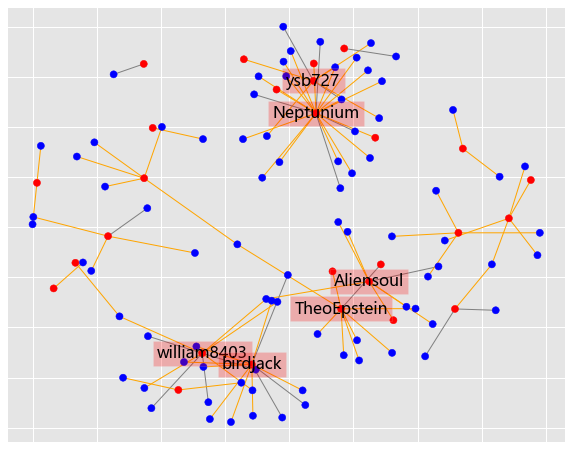

In [127]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G,k=0.3)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

從此圖中能發現大部分留言者發言皆是與主題1相關。

### 5.5 使用者是否受到歡迎
PTT的回覆有三種，推文、噓文、箭頭，我們只要看推噓就好，因此把箭頭清掉。

In [128]:
# 加上status
status_0522 = pd.merge(link_0522,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic","cmtStatus"]].drop_duplicates()
# 去掉"→"的資料
status_0522 = status_0522[status_0522["cmtStatus"]!="→"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [129]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_0522_status = pd.merge(status_0522,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_0522_status.reset_index(inplace=True, drop=True) #重設index
link_0522_status.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cmtPoster,artUrl,topic,cmtStatus,artPoster
0,Atkins13,https://www.ptt.cc/bbs/HatePolitics/M.16349991...,1.0,推,ysb727
1,CYL009,https://www.ptt.cc/bbs/HatePolitics/M.16350814...,0.0,推,Neptunium
2,ChangWufei,https://www.ptt.cc/bbs/Gossiping/M.1634988495....,0.0,噓,jk182325


In [130]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge_S = []
for i in range(0,len(link_0522_status)):
    G.add_edge(link_0522_status["cmtPoster"][i], link_0522_status["artPoster"][i])
    if link_0522_status["cmtStatus"][i] == "推":
        color_map_edge_S.append('orange')
    else: 
        color_map_edge_S.append('grey')   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [131]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [132]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]

# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


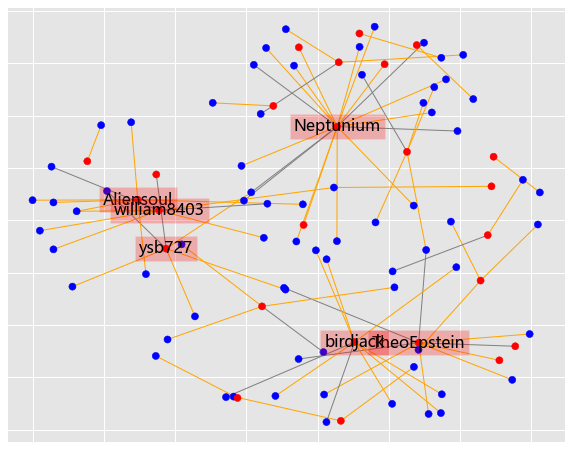

In [133]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=0.4)
# pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge_S,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

本次討論以推文居多，噓文的數量較少。